# SkimLit - NLP project

In [1]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git # get the data here
# !ls pubmed-rct

In [2]:
data_dir = 'PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt']

## Data Preprocessing

In [5]:
# Function to read the lines of a document
def get_lines(filename):
    with open(filename, 'r') as file:
        return file.readlines()
    
# Read in the training lines
train_lines = get_lines(data_dir + 'train.txt') 

In [6]:
def preprocess_text_with_lines(filename):
    input_lines = get_lines(filename)
    abstract_lines = "" # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = "" # Reset the abstract string if the line starts with '###'
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionary for each line
                target_text_split = abstract_line.split('\t') # Split target label from text
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower() # Get target text and lower it
                line_data['line_number'] = abstract_line_number # What number line does the line appear in the abstract?
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data) # Append line data to abstract samples list
        else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [7]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_lines(data_dir + 'train.txt')
val_samples = preprocess_text_with_lines(data_dir + 'dev.txt') 
test_samples = preprocess_text_with_lines(data_dir + 'test.txt')

In [8]:
# Turn the abstract lines into DataFrames
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [9]:
# Distribution of labels in the training data
train_df['target'].value_counts()

target
RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: count, dtype: int64

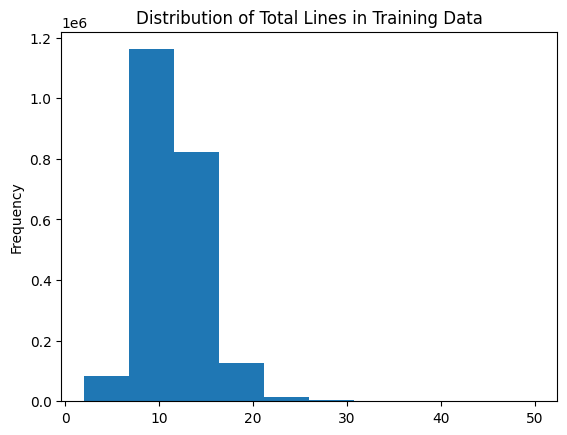

In [10]:
train_df.total_lines.plot.hist()
plt.title("Distribution of Total Lines in Training Data");

In [11]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [12]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

In [13]:
# Get class names and number of classes from LabelEncoder instance
class_names = one_hot_encoder.categories_[0]
num_classes = len(class_names)
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

### Character Embeddings

#### Creating a character-level tokenizer

In [14]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [15]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [16]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(147.82646377869133)

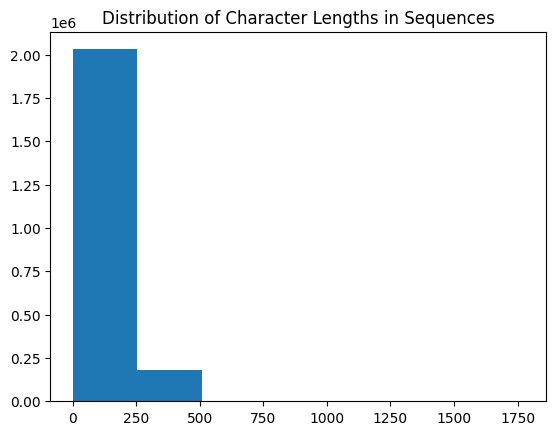

In [17]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)
plt.title("Distribution of Character Lengths in Sequences")
plt.show()

Most of our sequences are between 0 and 250 characters long, use percentile to figure out what length covers 95% of our sequences.

In [18]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

Now we know the sequence length which covers 95% of sequences, we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

In [19]:
# Get all keyboard characters for char-level embedding
import string
from tensorflow.keras.layers import TextVectorization
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, 
                                    output_sequence_length=output_seq_char_len, 
                                    name="char_vectorizer",
                                    standardize="lower_and_strip_punctuation") # None if you don't want punctuation removed
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [20]:
len(char_vectorizer.get_vocabulary())

28

#### Creating a character-level embedding

In [21]:
# Create char embedding layer
from tensorflow.keras.layers import Embedding
cahr_vocab = char_vectorizer.get_vocabulary()
char_embed = Embedding(input_dim=len(cahr_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name="char_embed")

### Create positional embeddings

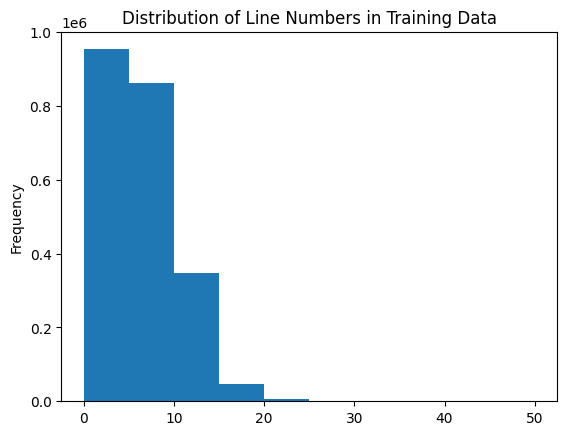

In [22]:
# Check the distribution of line numbers
train_df['line_number'].plot.hist()
plt.title("Distribution of Line Numbers in Training Data");

In [23]:
np.percentile(train_df['line_number'], 98)

np.float64(15.0)

In [24]:
# Create one-hot-encoded tensors of our line numbers
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

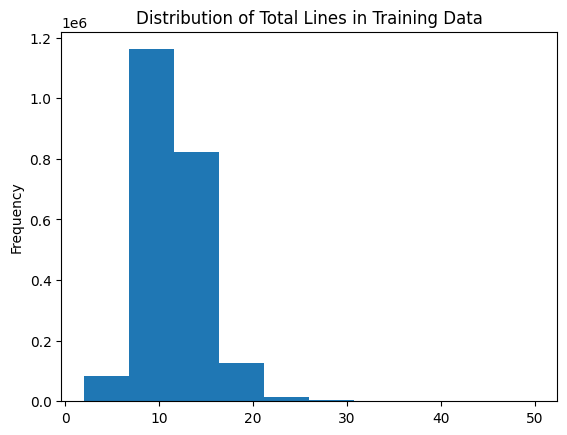

In [25]:
# Check the distribution of total lines
train_df['total_lines'].plot.hist()
plt.title("Distribution of Total Lines in Training Data");

In [26]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df['total_lines'], 98)

np.float64(20.0)

In [27]:
# Create one-hot-encoded tensors of our total lines
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

### Pretrainde token embedding USE

In [28]:
# Prepare Universal Sentence Encoder (USE)
from tensorflow.keras import Layer
import tensorflow_hub as hub 
# Path to the Universal Sentence Encoder model
path = "universal-sentence-encoder/2"
# Download USE here https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true
# Load the USE model from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer(path, input_shape=[], dtype=tf.string, trainable=False)

# Define a custom Keras Layer that uses the USE model for embedding
class Embedding(Layer):
    def call(self, x):
        return tf_hub_embedding_layer(x)